# Jupyter Notebook zum Import/Export, zur Analyse und Darstellung von Zeitreihendaten
[python-Module: *pandas, matplotlib, numpy*]


## 1. Benötigte Module laden


In [11]:
import pandas as pd
import funx 
import numpy as np
import matplotlib.pyplot as plt
df=funx.startup()

## 2. Datenframe von csv-Dateien einlesen
### Parameter festlegen:
***ndays***   ...Anzahl der Tage, die von heute rückblickend dargestellt werden sollen

In [12]:
ndays=7#beliebig wählbar 
df=funx.getdf_frommulticsv(ndays)
#df.head() #zeigt die ersten 5 Zeilen

## 3. Datenframe ergänzen/analysieren
- Hinzufügen von Spalten mit NaN-Analyse-Werten 
- Ausgabetabelle mit NaN-Werten für jeden Tag

In [13]:
df=df.resample("1min").max() #erstellt für jede Minute eine Messwertzeile und übernimmt vorhandene Werte, Lücken erhalten den Wert: NAN
df['nan']=np.where((df.isnull().all(1)),1,0)  #legt eine Spalte 'nan' an: 1 kein Messwert in Minutenreihe, 0 Messwerte vorhanden
df['nanr']=np.where((df['mabs'].notna()==0)&(df['nan']==0),1,0)  #Spalte nanr, Regenwert fehlt: 1; Regenwert vorhanden oder ganze Zeile fehlt:0
cols=['nan','nanr']
df['nan_sum']=df[cols].sum(axis=1).groupby(df.index.date).cumsum()  #Summenlinie beider nan-Werte mit täglichem Reset
df['nan_sum'].groupby(df.index.date).max()

2020-03-12    0
2020-03-13    0
2020-03-14    0
2020-03-15    0
2020-03-16    0
2020-03-17    0
2020-03-18    0
Name: nan_sum, dtype: int64

## 4. Datenframe plotten

Erzeugen eines Multi-Linien-Plots

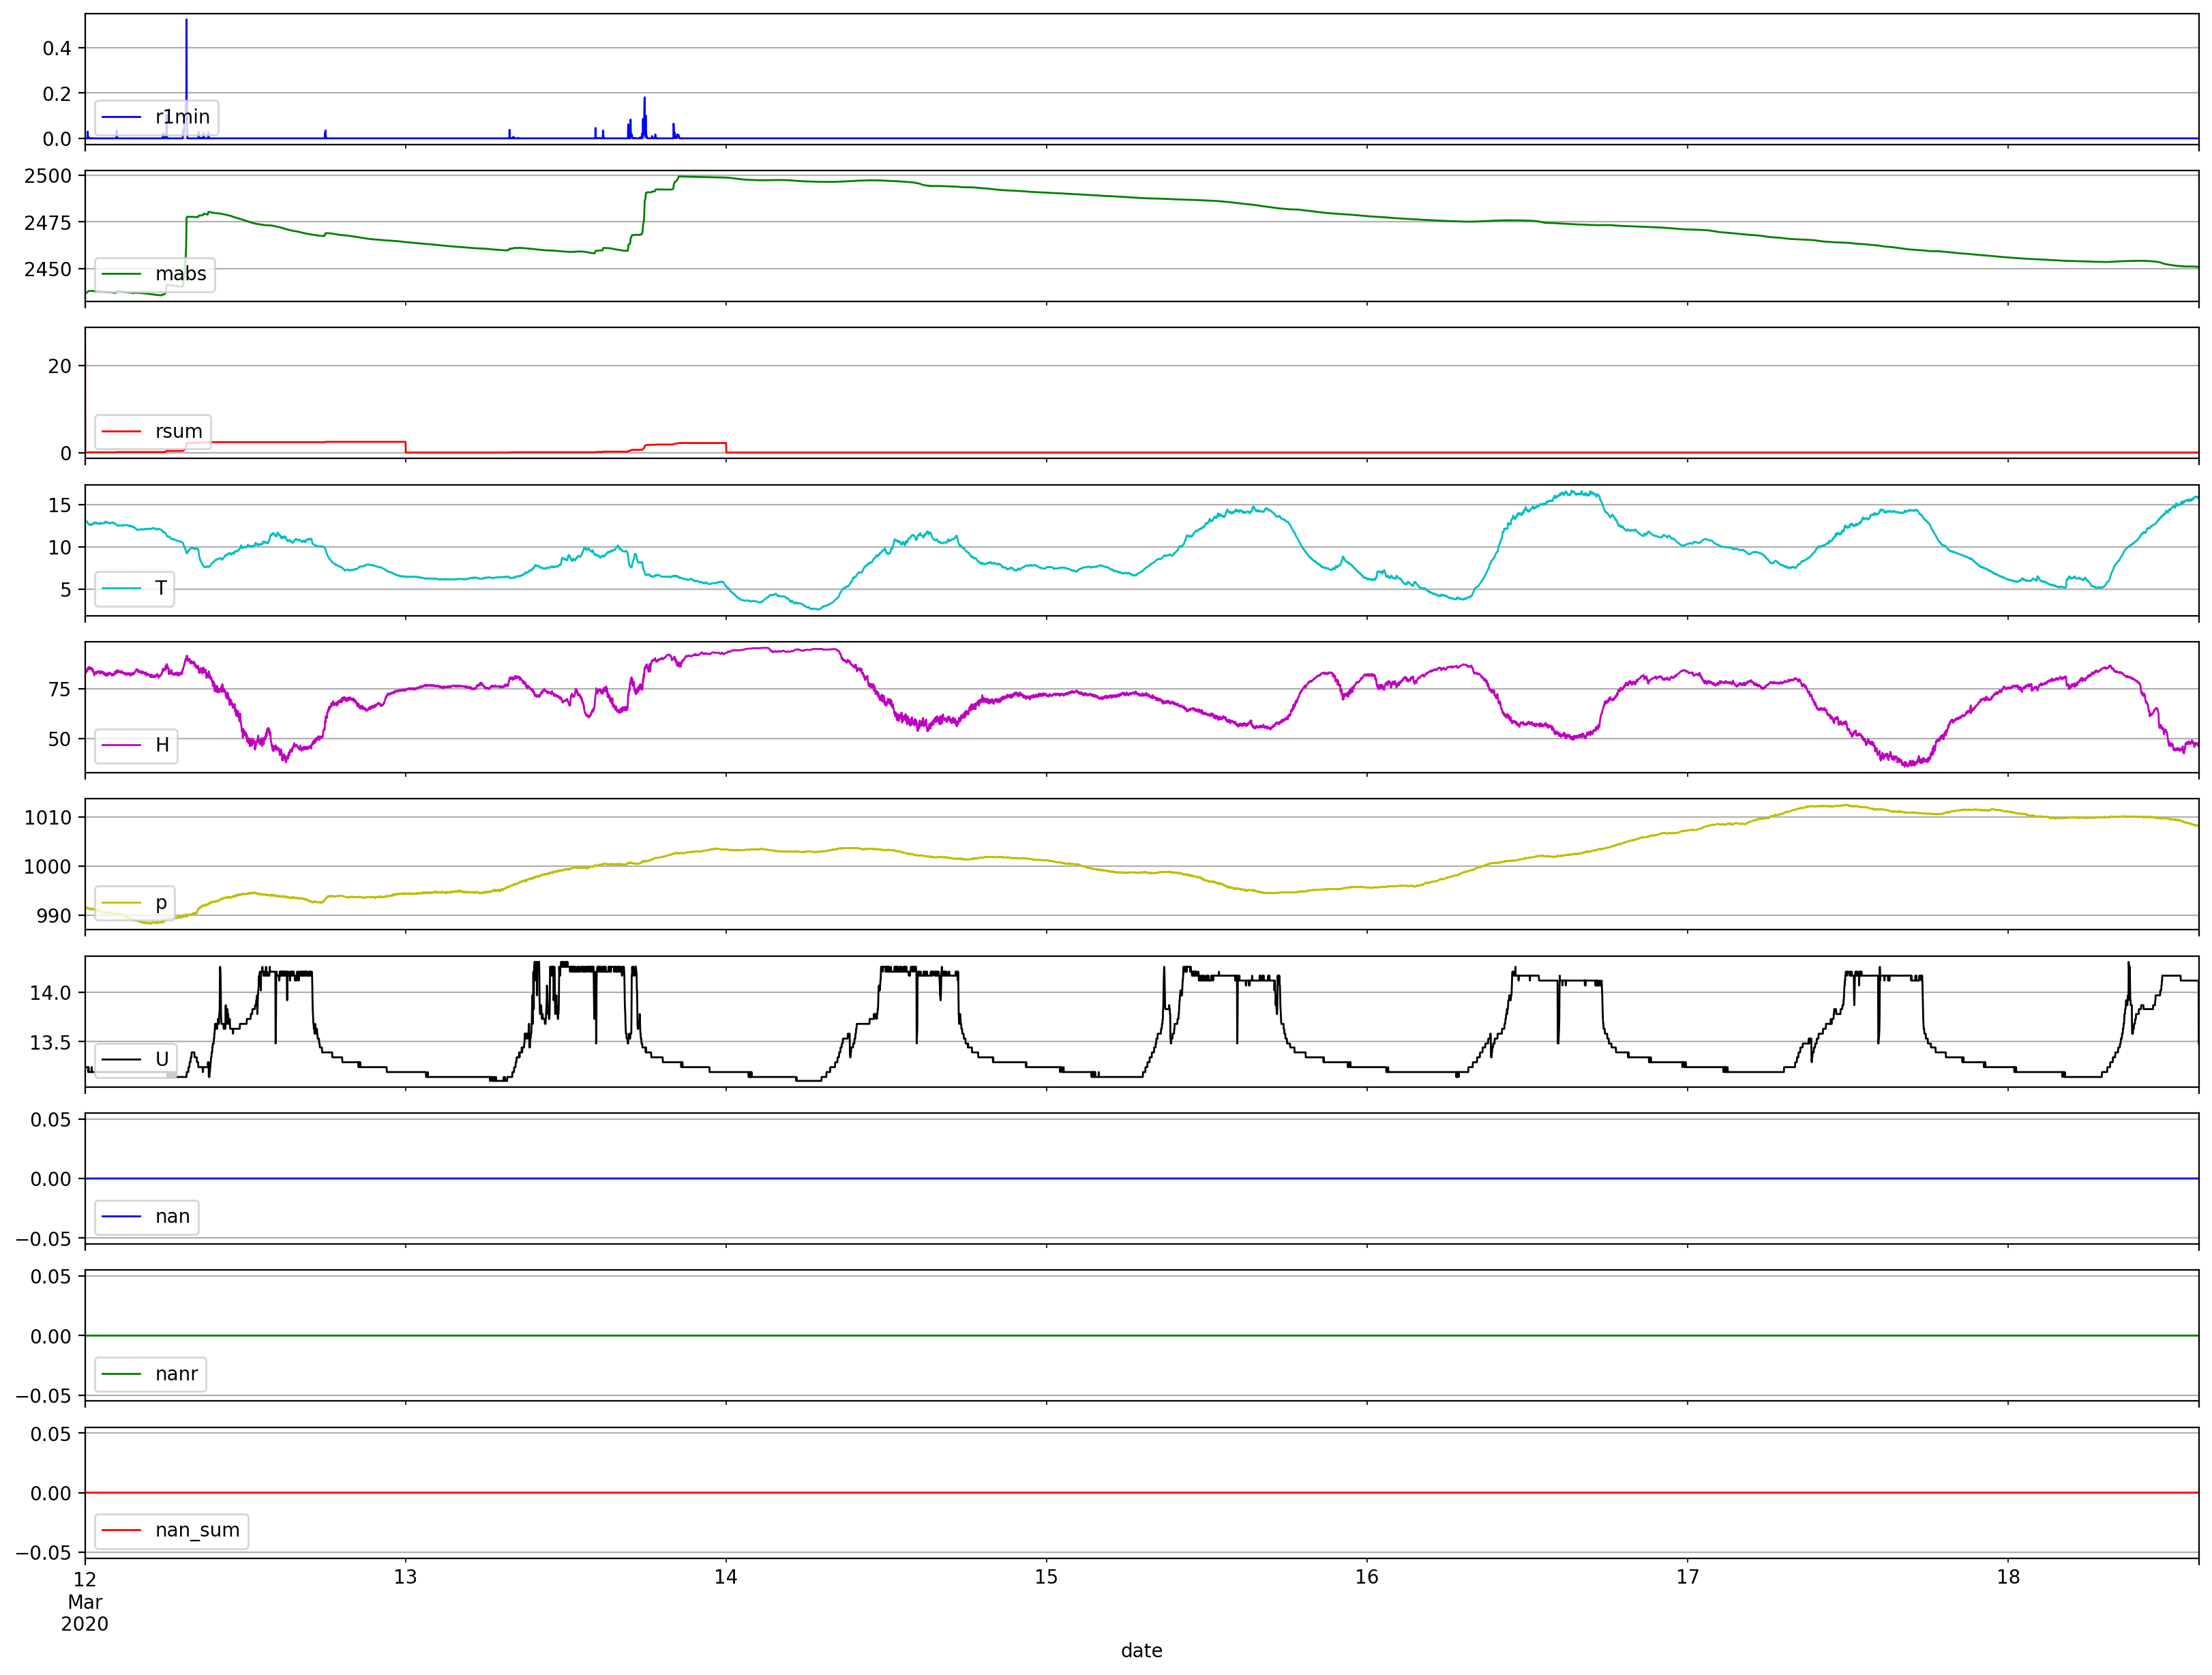

In [14]:
## Darstellung der ganzen Zeitspanne
startdate=str(df.index[0])
enddate=str(df.index[-1])
## alternativ: Festlegen eines Zeitabschnitts zur Darstellung
#startdate="2020-02-26 00:00:00"
#enddate="2020-02-26 18:00:00"

funx.plotdf(df,startdate,enddate)
plt.savefig('myplot.png',dpi=300)



## 5. Export der Daten

* Datenframe als csv-Datei, xlsx-Datei (mit Diagrammen) und png-Datei der dargestellten Plots
* Dateien manuell lokal speichern (Menüaufruf: siehe Screenshot)

<img src="image1.png" width="300">

In [15]:
df.to_csv('mycsv.csv')
funx.exportdf_toexcel_withcharts(df,'MyExcelFile.xlsx')